# 实验3 图像空间域滤波处理

## 3-1：实现图像的高斯滤波处理

实验要求：

1.  通过调整高斯函数的标准差(sigma)来控制平滑程度；

    给定函数：`void Gaussian(const MyImage &input, MyImage &output, double sigma);`

2.  滤波窗口大小取为$[6\sigma - 1] / 2 \times 2 + 1$，$[.]$表示取整；
3.  利用二维高斯函数的行列可分离性进行加速；
    - 先对每行进行一维高斯滤波，再对结果的每列进行同样的一维高斯滤波；
    - 空间滤波=图像卷积；
    - 高斯滤波=以高斯函数为卷积核的图像卷积。

首先导入所需的库

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

读取图像

In [2]:
image = cv2.imread("imgs/Lab3/3-1.jpg")

接着实现Gaussian函数

In [3]:
def Gaussian(input, output, sigma):
    ksize = int(6 * sigma - 1) // 2 * 2 + 1  # 滤波窗口大小
    k = cv2.getGaussianKernel(ksize, sigma)  # 生成一维高斯核
    k = np.outer(k, k)  # 将一维高斯核转换为二维高斯核

    # 对每行进行一维高斯滤波
    output = cv2.filter2D(input, -1, k)

    # 对结果的每列进行一维高斯滤波
    output = cv2.filter2D(output, -1, k.T)

    return output

准备滤波后的新图像

In [4]:
output = np.zeros_like(image)

# 调整高斯函数的标准差来控制平滑程度
sigma = 1.5

# 应用高斯滤波
output = Gaussian(image, output, sigma)

显示原图和滤波后的图像

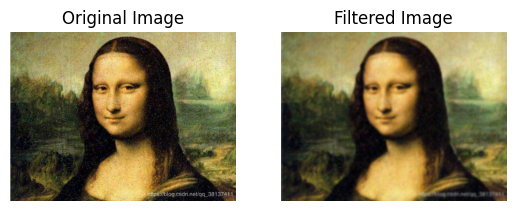

In [5]:
plt.subplot(121)
plt.title("Original Image")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title("Filtered Image")
plt.axis("off")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

plt.show()

## 3-2：实现图像的联合双边滤波处理

实验要求：

给定函数：`function im = jbf(D, C, w, sigma_f, sigma_g)`

其中：

- `D`为输入图像；`C`为引导图像；`W`为滤波窗口大小；
- `sigma_f`为spatial kernel标准差；
- `sigma_g`为range kernel标准差；

给定公式：

$$
J_{p} = \frac{
    \sum_{q \in \Omega} f(||p-q||) \cdot g(|\tilde{I}_{p} - \tilde{I}_{q}|) \cdot I_{q}
}{
    \sum_{q \in \Omega} f(||p-q||) \cdot g(|\tilde{I}_{p} - \tilde{I}_{q}|)
}
$$

其中：$p$是$q$的邻域$\Omega$中的一个像素。$f$和$g$是空间和距离内核，通常以高斯的形式标识，$I$是输入图像。

- $f$是空间滤波器内核，定义为：$\exp(-d_f^2 / 2\sigma_f^2)$；
  - 其中：$d_f$为输入图像$I$的像素位置差
  - $\sigma_f$为空间滤波核函数的标准差
- $g$是距离滤波器内核，定义为：$\exp(-d_g^2 / 2\sigma_g^2)$；
  - 其中：$d_g$为引导图像$\tilde{I}$的像素灰度值差
  - $\sigma_g$为滤波核函数的标准差

输入图像$I$通过下采样\(1/2\)得到LR低分辨率图像，再由LR图像上采样2倍得到引导图像。

图像缩放采用双线性插值。

首先准备上采样和下采样的函数

In [6]:
def downsample_image(image):
    height, width = image.shape[:2]
    new_height = height // 2
    new_width = width // 2 + 1
    downsampled_image = cv2.resize(
        image, (new_width, new_height), interpolation=cv2.INTER_LINEAR
    )
    return downsampled_image

In [7]:
def upsample_image(image):
    height, width = image.shape[:2]
    new_height = height * 2
    new_width = width * 2
    upsampled_image = cv2.resize(
        image, (new_width, new_height), interpolation=cv2.INTER_LINEAR
    )
    return upsampled_image

由此可以写出获得引导图像的函数

In [8]:
def getGuideImage(image):
    downsampled_image = downsample_image(image)
    guide = upsample_image(downsampled_image)
    return guide

实现`jbf`函数（也就是联合双边滤波）

In [9]:
def jbf(D, C, w, sigma_f, sigma_g):
    im = np.zeros_like(D)
    D = cv2.GaussianBlur(D, (5, 5), 0)

    # 计算滤波窗口半径
    radius = w // 2

    # 对每个像素进行滤波
    for i in range(radius, D.shape[0] - radius):
        for j in range(radius, D.shape[1] - radius):
            # 获取滤波窗口
            window = D[i - radius : i + radius + 1, j - radius : j + radius + 1]

            # 计算空间滤波器内核
            d_f = np.sqrt((window - D[i, j]) ** 2)
            f = np.exp(-(d_f**2) / (2 * sigma_f**2))

            # 计算距离滤波器内核
            d_g = np.sqrt(
                (C[i - radius : i + radius + 1, j - radius : j + radius + 1] - C[i, j])
                ** 2
            )
            g = np.exp(-(d_g**2) / (2 * sigma_g**2))

            # 计算权重
            weight = f * g

            # 归一化权重
            weight /= np.sum(weight)

            # 计算输出像素值
            im[i, j] = np.sum(window * weight)
    return im

现在设置`jbf`函数中的`D`和`C`

In [10]:
D = cv2.imread("imgs/Lab3/3_2.png")
C = getGuideImage(D)

指定相关参数

In [11]:
w = 5
sigma_f = 0.1
sigma_g = 0.5

应用`jbf`函数

In [12]:
# 将图像分割为三个通道
b, g, r = cv2.split(D)
# 将引导图像分成三个通道
Cb, Cg, Cr = cv2.split(C)
# 将`jbf`分别应用于每个通道
b_filtered = jbf(b, Cb, w, sigma_f, sigma_g)
g_filtered = jbf(g, Cg, w, sigma_f, sigma_g)
r_filtered = jbf(r, Cr, w, sigma_f, sigma_g)
# 将通道重新合并在一起
output = cv2.merge([b_filtered, g_filtered, r_filtered])
# 否则，直接应用`jbf`得到的则是灰度图像
# output = jbf(D, C, w, sigma_f, sigma_g)

显示图像

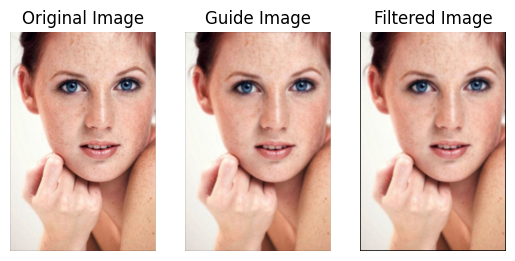

In [13]:
plt.subplot(131)
plt.title("Original Image")
plt.axis("off")
plt.imshow(cv2.cvtColor(D, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.title("Guide Image")
plt.axis("off")
plt.imshow(cv2.cvtColor(C, cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.title("Filtered Image")
plt.axis("off")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

plt.show()